# Merging with a Robust Error Model  

In the previous example, we computed the common merging statistics $CC_{1/2}$ and $CC_{anom}$ to explore a dataset with significant anomalous signal from native sulfur atoms. One assumption that we made while merging is that the scaled reflection observations are normally distributed about the mean. This assumption is consistent with the merging strategy used by [AIMLESS](https://doi.org/10.1107/S0907444913000061), which was used to scale the data in the first place. In this example, we will explore whether the scaled reflection observations are normally distributed, and whether we can improve the anomalous signal ($CC_{anom}$) by using a different error model.

*_Note:_ See https://pytorch.org/ for customizable PyTorch installation instructions.*

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context("notebook", font_scale=1.3)
from tqdm.notebook import tqdm
import torch

In [2]:
import reciprocalspaceship as rs

In [3]:
print(rs.__version__)

0.9.3


---
<a id='normalassumption'></a>
### Normal Error Model  

It is common in merging to assume that scaled intensities are normally distributed about the true mean. We can assess the validity of this assumption by looking at the residuals between scaled intensities and the maximum likelihood esimate of their true intensity.

In [4]:
ds = rs.read_mtz("data/HEWL_unmerged.mtz")

In [5]:
merged_normal = rs.algorithms.merge(ds)
merged_normal = merged_normal.stack_anomalous()

In [6]:
ds.hkl_to_asu(anomalous=True, inplace=True)
ds["IML"] = merged_normal.loc[ds.index, "I"]

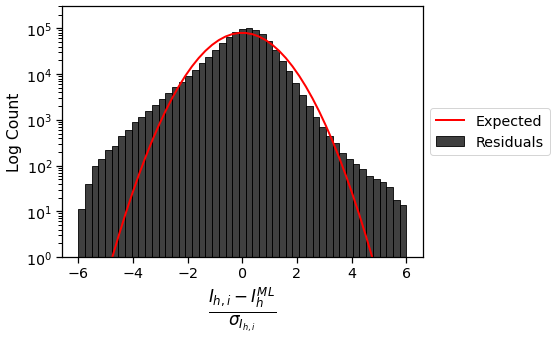

In [7]:
# Expected residuals for normally distributed data
x = np.linspace(-6., 6., 50)
bin_width = x[1] - x[0]
normal = bin_width*ds.shape[0]*(1/np.sqrt(2*np.pi))*np.exp(-0.5*x**2)

# Histogram Residuals
fig = plt.figure(figsize=(8, 5))
sns.histplot((ds.I - ds.IML)/ds.SIGI, bins=x, color="k", label="Residuals")
plt.plot(x, normal, 'r-', lw=2, label="Expected")
plt.ylabel("Log Count")
plt.yscale("log")
plt.ylim(1e0, 3e5)
plt.xlabel(r"$\frac{I_{h,i} - I^{ML}_{h}}{\sigma_{I_{h,i}}}$", fontsize=24)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

These residuals are not symmetric about $0$, which would have been expected for truly normally distributed data. In addition, the tails are much "heavier" than for a normal distribution. This suggests that it may be possible to do a better job merging these scaled observations by using a different error model that is more robust to outliers.

---
### Generalized Merging with Flexible Error Model

The inverse-variance weighting scheme implemented in `rs.algorithms.merge()` is the maximum likelihood estimator for the true mean if we assume the observations are normally distributed. 
However, we can write a more general form for the maximum likelihood estimator for the mean of each intensity distribution, $\mu \in\mathbb{R}^{|\mathbf{H}|}$, without assuming a specific distribution for the error model. 
Therefore, we will maximize the probability of the data given the model
\begin{align*}
P(data | model) &= \prod_{h,i}P(I_{h,i}|\mu_h, \sigma_{I_{h,i}}) 
\end{align*}
by minimizing the negative log likelihood
\begin{align*}
\mathcal{L} &\triangleq -\log P(data | model) \\
&= -\sum_{h,i}\log P(I_{h,i}|\mu_h, \sigma_{I_{h,i}}) \\
I^{ML} &= \underset{\mu}{\mathrm{argmin}}\ -\sum_{h,i} \log P(I_{h,i} | \mu_h, \sigma_{I_{h,i}}) 
\end{align*}
with respect to $\mu$. With this formulation, it is possible to supply any parametric form for the error model belonging to the [location-scale family](https://en.wikipedia.org/wiki/Location%E2%80%93scale_family) of distributions. This maximum likelihood estimator is implemented in the function below.

In [8]:
def merge_mle(ds, distribution, *args, lr=.5, progress_bar=True, return_loss=False, **kwargs):
    """
    Merge observations using the provided distribution as an error model.
    Additional arguments or keyword arguments will be passed to the PyTorch 
    distribution constructor.
    
    Parameters
    ----------
    ds : rs.DataSet
        Scaled, unmerged observations
    distribution : torch.distributions.Distribution
        PyTorch distribution to use as error model
    lr : float
        Learning rate for Adam optimizer
    progress_bar : bool
        Whether to display a progress bar for optimization
    return_loss : bool
        Whether to return the loss function values during optimization
        
    Returns
    -------
    rs.DataSet or (rs.DataSet, losses)
        Merged DataSet with or without list of loss function values
    """
    # Compute MLE with normal error model
    ds = ds.copy()
    mle_norm = rs.algorithms.merge(ds).stack_anomalous()
    ds["IML"] = mle_norm.loc[ds.index, "I"]
    
    # Observed intensities and error estimates
    groupby = ds.groupby(['H', 'K', 'L'])
    idx = groupby.ngroup().to_numpy()
    I = torch.as_tensor(ds.I.to_numpy())
    SigI = torch.as_tensor(ds.SIGI.to_numpy())
    
    # Initialize optimization at MLE with normal error model
    mle = groupby.first()["IML"].to_numpy()
    mean = torch.tensor(mle, requires_grad=True)
    
    # Define loss function
    def _evaluate_loss():
        return -torch.sum(distribution(*args, loc=mean[idx], scale=SigI, **kwargs).log_prob(I))

    # Setup and fit model
    losses = []
    opt = torch.optim.Adam([mean], lr=lr)    
    for _ in tqdm(range(300), disable=not progress_bar):
        opt.zero_grad()
        loss = _evaluate_loss()
        losses.append(loss.detach())
        loss.backward()
        opt.step()
    grad = torch.autograd.grad(_evaluate_loss(), mean, create_graph=True)[0]
    hess = torch.autograd.grad(grad.sum(), mean, create_graph=True)[0]
    
    # Package results
    results = rs.DataSet({'I': mean.detach().numpy(), 
                          'SIGI': np.sqrt(1./hess.detach().numpy())},
                         index=groupby.first().index, 
                         spacegroup=ds.spacegroup,
                         cell=ds.cell, 
                         merged=True)
    results.infer_mtz_dtypes(inplace=True)

    if return_loss:
        return results.unstack_anomalous(), losses
    return results.unstack_anomalous()

This function must be passed a `torch.distribution.Distribution` to use as the error model. It then uses the [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) to minimize the negative log-likelihood and fit the merged intensities, $I^{ML}$. For stability, the model is initialized using the mean intensity values from `rs.algorithms.merge()`. The following cell fits the model using a [Student's _t_-distributed error model](https://pytorch.org/docs/stable/distributions.html#studentt) with `df=4.0`.

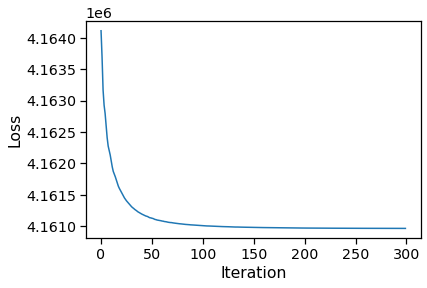

In [9]:
result1, loss1 = merge_mle(ds, torch.distributions.StudentT, 4.0, 
                           progress_bar=True, return_loss=True)

# Plot loss function
plt.plot(loss1)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [10]:
result1.sample(5)

,,,I(+),SIGI(+),I(-),SIGI(-)
H,K,L,,,,
18,10,11,908.22,16.894312,950.26495,15.516294
42,12,4,81.96461,3.8575513,81.2384,3.6594756
30,1,4,86.086655,1.9275732,89.02299,1.8141998
29,0,15,44.473648,3.4381435,44.473648,3.4381435
28,7,14,31.249847,1.8343532,27.27926,2.070762


As a sanity check we can test this implementation by passing the normal distribution as the error model. In this case, the initial values should match the maximum likelihood estimate and optimization should not change the estimates. 

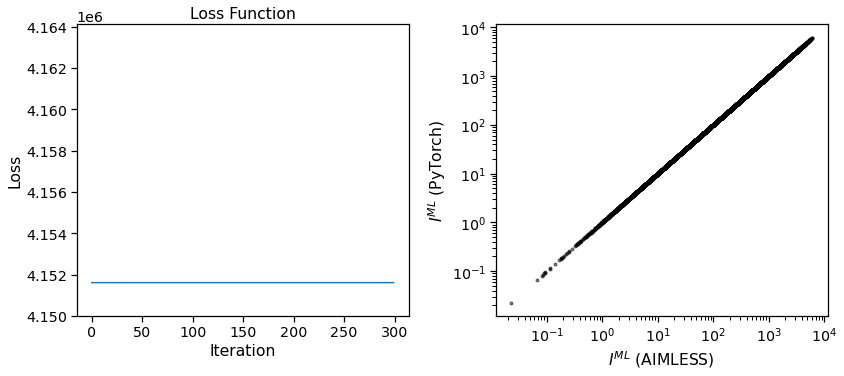

In [11]:
result2, loss2 = merge_mle(ds, torch.distributions.Normal, lr=1e-3,
                           progress_bar=True, return_loss=True)
result2 = result2[["I(+)", "SIGI(+)", "I(-)", "SIGI(-)"]].stack_anomalous()

# Plot loss function
fig, ax = plt.subplots(ncols=2, figsize=(12, 5.5))
ax[0].plot(loss2)
ax[0].set_ylim(4.15e6, max(loss1))
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss Function")
ax[1].loglog(merged_normal["I"], result2.loc[merged_normal.index, "I"], "k.", alpha=0.5)
ax[1].set_xlabel(r"$I^{ML}$ (AIMLESS)")
ax[1].set_ylabel(r"$I^{ML}$ (PyTorch)")
plt.tight_layout()
plt.show()

We can see here that the loss function does not change during the optimization, and that the final maximum likelihood estimates for the intensities are equivalent to the input. This validates that the merging function is working as expected.

---
### Assess Student's _t_-Distributed Error Model

A Student's _t_-distribution is useful in modeling data that contain outliers. This distribution places more density in the tails than a normal which makes maximum likelihood estimates robust to outlying measurements. It is parameterized by a degree of freedom, $\nu$, which can take a value between $[0, \infty)$ and controls the heaviness of the tails. As $\nu\to\infty$, the probability density function approaches a normal distribution.

Below, we will set up a few helper functions for merging our data within randomly partitioned half-datasets. We will do this for the Student's t-distribution scanning several degrees of freedom and for the normal distribution so that we can compare the results. Based on the previous example, we will compute $CC_{anom}$ using a Spearman correlation coefficient and repeated 2-fold cross-validation to compare the different error models.

In [12]:
def sample_halfdatasets(data):
    """Randomly split DataSet into two equal halves by BATCH"""
    batch = data.BATCH.unique().to_numpy(dtype=int)
    np.random.shuffle(batch)
    halfbatch1, halfbatch2 = np.array_split(batch, 2)
    half1 = data.loc[data.BATCH.isin(halfbatch1)]
    half2 = data.loc[data.BATCH.isin(halfbatch2)]
    return half1, half2

In [13]:
def merge_dataset(dataset, nsamples, distribution, *args, **kwargs):
    """
    Merge dataset with repeated 2-fold cross-validation using `distribution`
    as error model.
    """
    dataset = dataset.copy()
    samples = []
    for n in tqdm(range(nsamples)):
        half1, half2 = sample_halfdatasets(dataset)
        mergedhalf1 = merge_mle(half1, distribution, *args, progress_bar=False, **kwargs)
        mergedhalf2 = merge_mle(half2, distribution, *args, progress_bar=False, **kwargs)
        result = mergedhalf1.merge(mergedhalf2, on=["H", "K", "L"], suffixes=(1, 2))
        result["sample"] = n
        samples.append(result)
    return rs.concat(samples).sort_index()

In [14]:
def merge_dataset_normal(dataset, nsamples):
    """
    Merge dataset with repeated 2-fold cross-validation using normal distribution
    as error model.
    """
    dataset = dataset.copy()
    samples = []
    for n in tqdm(range(nsamples)):
        half1, half2 = sample_halfdatasets(dataset)
        mergedhalf1 = rs.algorithms.merge(half1)
        mergedhalf2 = rs.algorithms.merge(half2)
        result = mergedhalf1.merge(mergedhalf2, on=["H", "K", "L"], suffixes=(1, 2))
        result["sample"] = n
        samples.append(result)
    return rs.concat(samples).sort_index()

*Note:* Using these settings, the following will take 15-30 min to complete. It is possible to run into occasional numerical instabilities when computing the Hessian for `df=4.0`, but these will only impact $\sigma_I^{ML}$ estimates which are not used here. 

In [15]:
merged_df4 = merge_dataset(ds, 15, torch.distributions.StudentT, 4.0)
merged_df8 = merge_dataset(ds, 15, torch.distributions.StudentT, 8.0)
merged_df16 = merge_dataset(ds, 15, torch.distributions.StudentT, 16.0)
merged_df32 = merge_dataset(ds, 15, torch.distributions.StudentT, 32.0)
merged_df64 = merge_dataset(ds, 15, torch.distributions.StudentT, 64.0)

<ipython-input-8-9b4c2c344106>:58: RuntimeWarning: invalid value encountered in sqrt
  'SIGI': np.sqrt(1./hess.detach().numpy())},


In [16]:
merged_dfinf = merge_dataset_normal(ds, 15)

Now that we have merged the data using Student's _t_-distributions and a normal distribution as the error model, we can compute $CC_{anom}$ and plot the results by resolution bin.

In [17]:
def computeCC(merged, bins=12):
    """Compute CCanom for input data"""
    merged, labels = merged.assign_resolution_bins(bins=bins)
    merged = merged.loc[~merged.label_centrics().CENTRIC]
    merged["ANOM1"] = merged["I(+)1"] - merged["I(-)1"]
    merged["ANOM2"] = merged["I(+)2"] - merged["I(-)2"]
    groupby = merged.groupby(["sample", "bin"])[["ANOM1", "ANOM2"]]
    spearman = groupby.corr(method="spearman").unstack().loc[:, ("ANOM1", "ANOM2")]
    results = spearman.groupby("bin").agg(["mean", "std"])
    return results, labels

In [18]:
resultsinf, labels = computeCC(merged_dfinf)
results4, labels = computeCC(merged_df4)
results8, labels = computeCC(merged_df8)
results16, labels = computeCC(merged_df16)
results32, labels = computeCC(merged_df32)
results64, labels = computeCC(merged_df64)

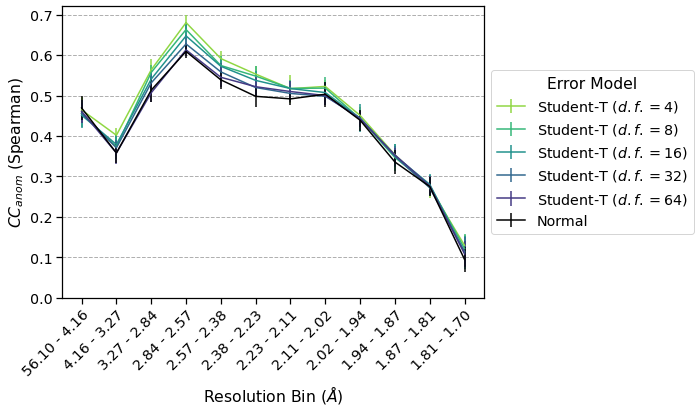

In [19]:
def plot(results, label, ax, color=None):
    ax.errorbar(results.index, results["mean"], yerr=results["std"], color=color, label=label)
    return

fig = plt.figure(figsize=(10, 6))
ax = fig.gca()
with sns.color_palette("viridis", 5) as palette:
    plot(results4, r"Student-T ($d.f.=4$)", ax, color=palette[4])
    plot(results8, r"Student-T ($d.f.=8$)", ax, color=palette[3])
    plot(results16, r"Student-T ($d.f.=16$)", ax, color=palette[2])
    plot(results32, r"Student-T ($d.f.=32$)", ax, color=palette[1])
    plot(results64, r"Student-T ($d.f.=64$)", ax, color=palette[0])
plot(resultsinf,"Normal", ax, color="k")
plt.ylabel(r"$CC_{anom}$ (Spearman)")
plt.xlabel(r"Resolution Bin ($\AA$)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Error Model")
plt.ylim(0, 0.72)

plt.xticks(resultsinf.index, labels, rotation=45, ha='right', rotation_mode='anchor')
plt.grid(axis="y", linestyle='--')
plt.tight_layout()
plt.show()

---
### Summary  

This dataset was scaled and merged in AIMLESS, which involves rounds of outlier rejection and implicitly assumes that the intensities are normally distributed about the true mean. In the [first section](#normalassumption), we observed that the residuals from merging are not normally distributed, suggesting that the normal error model may have been suboptimal. We implemented a more general maximum likelihood-based approach for merging data using different probability distributions and used it to evaluate the performance of Student's _t_-distributed error models. This seemed like a reasonable starting point because it is often more robust to outliers than a normal distribution. 

Using repeated 2-fold cross-validation, we saw that a Student's _t_-distribution with a low degree of freedom ($\nu=4$) outperforms the normally distributed error model when assessed using $CC_{anom}$. Furthermore, the performance seems to approach that of the normal distribution when the degree of freedom is increased, which is expected since the _t_-distribution approaches a normal disitrbution as $\nu\to\infty$.

Although this dataset is quite high quality and was used to phase and refine a model from the [native sulfur SAD signal](http://doi.org/10.2210/pdb7L84/pdb), it still shows that there can be an incremental improvement in $CC_{anom}$ from revisiting assumptions regarding error models during merging. This model is implemented in ~40 lines of code using `PyTorch`, and can be quickly applied to any dataset of interest. By lowering the barrier to implementing such models, `reciprocalspaceship` makes it easy to try new analyses and to revisit some of the assumptions made in crystallographic data reduction.